# Gaussian Process NARX Model
This notebook implements a proper NARX model using a Gaussian Process regressor with closed-loop prediction.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

In [55]:
def build_NARX_train(data, nu, ny):
    u = data[:, 0]
    y = data[:, 1]
    X, Y = [], []
    for k in range(max(nu, ny), len(u)):
        u_features = u[k - nu:k]
        y_features = y[k - ny:k]
        xk = np.concatenate([u_features, y_features])
        X.append(xk)
        Y.append(y[k])
    return np.array(X), np.array(Y)

def rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def build_NARX_prediction(data, i, na, nb):
    u = data[i, :nb]
    y = data[i, nb:nb + na + 1]

    xk = np.concatenate([u, y[:na]])
    yk = y[na]  # y[k]

    return xk.reshape(1, -1), np.array([[yk]])

def autoregressive_NARX_prediction_full(gp, u, y, na=15, nb=15, start_idx=50):
    y_pred_all = []
    y_history = list(y[:start_idx])  # use y[0] to y[49] as seed

    for k in range(start_idx, len(y)):
        u_window = u[k - nb:k]
        y_window = y_history[-na:]
        xk = np.concatenate([u_window, y_window]).reshape(1, -1)
        y_pred = gp.predict(xk)[0]
        y_pred_all.append(y_pred)
        y_history.append(y_pred)

    return np.array(y_pred_all)

In [56]:
train_data = pd.read_csv("training-val-test-data.csv")

nu, ny = 15, 15
X, Y = build_NARX_train(train_data.values[50:], nu, ny)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, shuffle=False
)

display(train_data)

,u,th
0,0.160293,0.000000
1,-0.028931,0.000000
2,-0.272356,0.000000
3,-0.532736,0.000000
4,-0.767692,0.000000
...,...,...
34995,-0.086309,-0.025133
34996,0.010582,-0.072257
34997,0.077204,-0.109956
34998,0.097081,-0.128805


In [57]:
# Train GP
kernel = C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
n_samples = 3000
indices = np.random.choice(len(X_train), n_samples, replace=False)
X_sub = X_train[indices]
Y_sub = Y_train[indices]
gp.fit(X_sub, Y_sub)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.1),
                         normalize_y=True)

In [84]:
Y_pred, Y_std = gp.predict(X_test, return_std=True)
RMSE_NARX = rmse(Y_pred, Y_test)
RMSE_NARX

# Y_train_pred, _ = gp.predict(X_train, return_std=True)
# RMSE_train = rmse(Y_train_pred, Y_train)
# RMSE_train

np.float64(0.003925671309668156)

In [87]:
ji = 0.003925671309668156 / 0.003575657830789095
ji = (ji-1)*100
ji

9.788785600937056

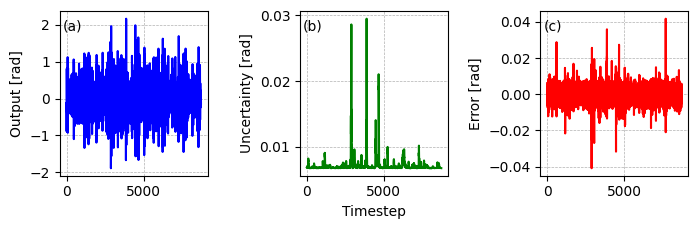

In [82]:
Err_Y = Y_test-Y_pred

fig, axs = plt.subplots(1, 3, figsize=(7.2, 2.5), sharex=False)

axs[0].plot(Y_pred, color="blue")
axs[0].set_ylabel("Output [rad]")
# axs[0].set_xlabel("Timestep")
axs[0].text(0.02, 0.95, '(a)', transform=axs[0].transAxes, fontsize=10, va='top')
axs[0].grid(True, linestyle='--', linewidth=0.5)

axs[1].plot(2 * Y_std, color="green")
axs[1].set_ylabel("Uncertainty [rad]")
axs[1].set_xlabel("Timestep")
axs[1].text(0.02, 0.95, '(b)', transform=axs[1].transAxes, fontsize=10, va='top')
axs[1].grid(True, linestyle='--', linewidth=0.5)

axs[2].plot(Err_Y, color="red")
axs[2].set_ylabel("Error [rad]")
# axs[2].set_xlabel("Timestep")
axs[2].text(0.02, 0.95, '(c)', transform=axs[2].transAxes, fontsize=10, va='top')
axs[2].grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout(pad=1.5)
plt.savefig("gp_results.pdf", format='pdf', bbox_inches='tight')
# plt.tight_layout()
plt.show()

In [35]:
pred_data = pd.read_csv('hidden-test-prediction-submission-file.csv')

X_all, Y_all, Y_pred_all, Y_std_all = [], [], [], []

for _ in range(len(pred_data)):
        X, Y = build_NARX_prediction(pred_data.values, _, na=15, nb=15)
        Y_pred, Y_std = gp.predict(X, return_std=True)
        
        X_all.append(X[0])
        Y_all.append(Y[0])
        Y_pred_all.append(Y_pred[0])
        Y_std_all.append(Y_std[0])

pred_data.iloc[:len(Y_pred_all), -1] = Y_pred_all
print(pred_data.columns)


Index(['# u[k-15]', ' u[k-14]', ' u[k-13]', ' u[k-12]', ' u[k-11]', ' u[k-10]',
       ' u[k-9]', ' u[k-8]', ' u[k-7]', ' u[k-6]', ' u[k-5]', ' u[k-4]',
       ' u[k-3]', ' u[k-2]', ' u[k-1]', ' y[k-15]', ' y[k-14]', ' y[k-13]',
       ' y[k-12]', ' y[k-11]', ' y[k-10]', ' y[k-9]', ' y[k-8]', ' y[k-7]',
       ' y[k-6]', ' y[k-5]', ' y[k-4]', ' y[k-3]', ' y[k-2]', ' y[k-1]',
       ' y[k-0]'],
      dtype='object')


In [29]:
print("Train X example:", X_train[0])
print("Predict X example:", X[0])

Train X example: [ 0.16029299 -0.02893118 -0.27235568 -0.53273637 -0.76769229 -0.93646903
 -1.00653434 -0.95892522 -0.79146355 -0.51930343 -0.17271133  0.20756312
  0.57656875  0.89205539  1.12086335  0.          0.          0.
  0.          0.         -0.00314159 -0.00628319 -0.01570796 -0.03769911
 -0.06283185 -0.09424778 -0.12252211 -0.13823008 -0.13823008 -0.11938052]
Predict X example: [ 0.94223877  0.90531612  0.83927699  0.74522736  0.62611598  0.48722804
  0.33622928  0.18272205  0.03737377 -0.08923888 -0.18787221 -0.25173165
 -0.27727257 -0.26455507 -0.21710131  0.46809731  0.69429198  0.87964594
  1.00845124  1.07442469  1.07756628  1.02415921  0.91106187  0.74769905
  0.54035394  0.30787608  0.05654867 -0.18535397 -0.39898227 -0.57176986]


In [37]:
pred_data.to_csv('submission_pred.csv', index=False)
pred_data

,# u[k-15],u[k-14],u[k-13],u[k-12],u[k-11],u[k-10],u[k-9],u[k-8],u[k-7],u[k-6],...,y[k-9],y[k-8],y[k-7],y[k-6],y[k-5],y[k-4],y[k-3],y[k-2],y[k-1],y[k-0]
0,0.597056,0.664717,0.660581,0.574940,0.411205,0.185510,-0.075802,-0.340382,-0.575046,-0.751047,...,-0.292168,-0.251327,-0.191637,-0.119381,-0.050265,0.006283,0.047124,0.065973,0.062832,0.046115
1,0.481245,0.942952,1.401479,1.807275,2.110139,2.265921,2.243056,2.027916,1.628116,1.073118,...,-0.053407,0.210487,0.480664,0.750841,0.973894,1.146681,1.250354,1.269203,1.200088,1.033409
2,-0.330248,-0.627526,-0.951448,-1.266759,-1.538908,-1.738397,-1.844305,-1.846530,-1.746480,-1.556196,...,0.047124,0.000000,-0.069115,-0.153938,-0.254469,-0.348717,-0.433540,-0.490088,-0.515221,-0.505202
3,-1.278566,-0.853534,-0.374212,0.102654,0.521251,0.833745,1.006296,1.023235,0.888845,0.626505,...,-0.477522,-0.355000,-0.194779,-0.003142,0.201062,0.389557,0.552920,0.678584,0.719425,0.703198
4,0.479845,0.386787,0.264334,0.119787,-0.034593,-0.183386,-0.310445,-0.401580,-0.447019,-0.443251,...,0.062832,-0.009425,-0.078540,-0.138230,-0.182212,-0.213628,-0.226195,-0.219911,-0.204204,-0.170123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,1.076848,1.118670,1.074839,0.955268,0.778343,0.567920,0.349687,0.147428,-0.020253,-0.142275,...,-0.571770,-0.358142,-0.116239,0.135088,0.361283,0.552920,0.694292,0.772832,0.782257,0.733982
641,0.206514,0.150052,0.178415,0.271080,0.395702,0.513564,0.586022,0.580982,0.478396,0.273933,...,1.178097,0.926770,0.625177,0.304734,-0.018850,-0.314159,-0.571770,-0.769690,-0.917345,-1.008120
642,-1.473435,-1.285536,-1.028843,-0.725182,-0.399810,-0.079282,0.210918,0.448769,0.617867,0.709070,...,-1.341460,-1.256637,-1.090133,-0.854513,-0.552920,-0.213628,0.144513,0.496372,0.813672,1.067180
643,0.691650,0.759858,0.800964,0.806801,0.771370,0.691962,0.569947,0.411109,0.225450,0.026476,...,0.442965,0.446106,0.427257,0.389557,0.333009,0.260752,0.172788,0.078540,-0.025133,-0.122855


In [38]:
sim_data = pd.read_csv('hidden-test-simulation-submission-file.csv')
u = sim_data.values[:, 0]
y = sim_data.values[:, 1].copy()

predicted_ys = autoregressive_NARX_prediction_full(
    gp,
    u=u,
    y=y,
    na=15,
    nb=15,
    start_idx=50
)

y[50:] = predicted_ys
sim_data.iloc[:, 1] = y

In [ ]:
sim_data[45:55]

,# u,th
45,-0.608924,0.468097
46,-0.292448,0.304734
47,0.047928,0.119381
48,0.366144,-0.078540
49,0.621433,-0.254469
50,0.783899,-0.394311
51,0.838333,-0.483187
52,0.785756,-0.514210
53,0.642503,-0.486885
54,0.437041,-0.406704


In [39]:
sim_data.to_csv('submission_sim.csv', index=False)

################ Simulation Result ##################
RMS= 0.5525 radians
RMS= 31.657 degrees
NRMS= 1678.42%


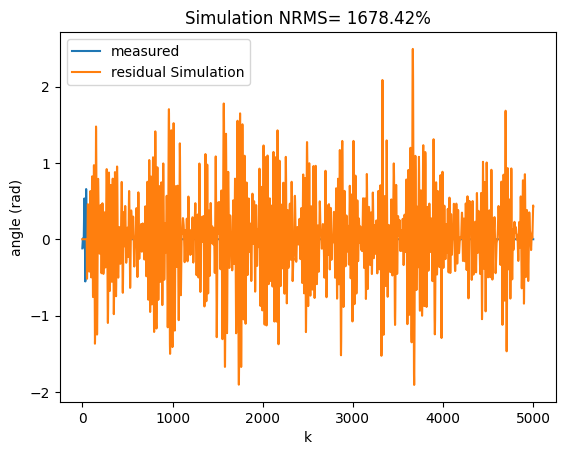

In [40]:
%run submission-file-checker.py submission_sim.csv hidden-test-simulation-submission-file.csv

In [48]:
%run example-simulation-solution.py

train prediction errors:
RMS: 0.005686082163369785 radians
RMS: 0.32578850992570535 degrees
NRMS: 1.1861875653354141 %
train simulation errors:
RMS: 0.3698141716560712 radians
RMS: 21.188791240019434 degrees
NRMS: 77.15113262843494 %


In [53]:
# # %run submission-file-checker.py submission_pred.csv hidden-test-prediction-example-submission-file.npz
# %run submission-file-checker.py submission_sim.csv hidden-test-simulation-example-submission-file.npz
%run example-prediction-solution.py


train prediction errors:
RMS: 0.0048969763527798044 radians
RMS: 0.28057607738964974 degrees
NRMS: 1.0215412195589235 %
